# 🥗 Predict Calorie Expenditure — Kaggle Playground S5E5  

<p align="center">
  <img src="https://anka-fitness.de/wp-content/uploads/2021/02/Kalorienrechner-kalorienbedarf-berechnen-kalorienverbrauch.jpg" alt="Running Calories" width="600"/>
</p>

## 📖 Introduction  

Calories burned during exercise depend on a combination of **personal attributes** (sex, age, height, weight) and **activity measurements** (duration, heart rate, body temperature).  
The goal of this Kaggle **Playground Series – Season 5, Episode 5** competition is to **predict calorie expenditure** based on these features.  

- **Task:** Regression  
- **Target:** `Calories`  
- **Metric:** RMSLE (Root Mean Squared Logarithmic Error)  
- **Dataset:** Synthetic dataset provided by Kaggle  

This notebook provides a **clean baseline** with data preprocessing, feature encoding, and a solid regression model (XGBoost).  
It is designed to be **simple, reproducible, and Kaggle-ready** for submission.  

---


In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# Kaggle competition input directory
DATA_DIR = "/kaggle/input/playground-series-s5e5"

train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
sample = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))


## 🔎 Quick Exploratory Data Analysis (EDA)

A short exploratory data analysis helps us understand the dataset structure, check for missing values, and visualize the target distribution.  
We will look at:
- Dataset overview  
- Missing values  
- Target (`Calories`) distribution  
- Correlations between numerical features  
- Feature relationships (scatter & categorical counts)  


In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample shape:", sample.shape)

Train shape: (750000, 9)
Test shape: (250000, 8)
Sample shape: (250000, 2)


In [4]:
# Basic info
train.info()
train.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Age,750000.0,41.420404,15.175049,20.0,28.00,40.0,52.00,79.0
Height,750000.0,174.697685,12.824496,126.0,164.00,174.0,185.00,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.00,74.0,87.00,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.00,15.0,23.00,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.00,95.0,103.00,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.60,40.3,40.70,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.00,77.0,136.00,314.0


In [5]:
# Missing values
train.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

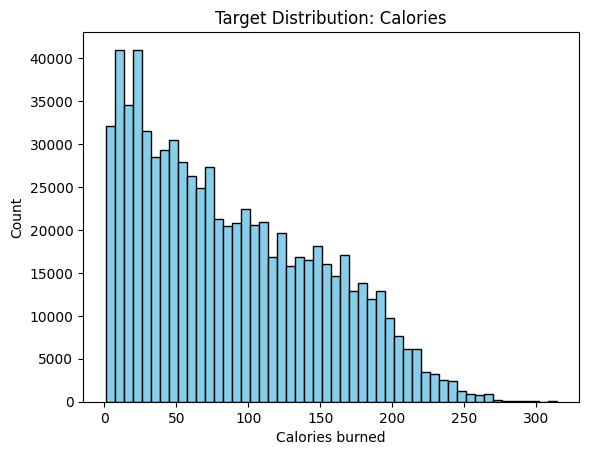

In [6]:
# Target distribution (Calories)
import matplotlib.pyplot as plt

plt.hist(train["Calories"], bins=50, color="skyblue", edgecolor="black")
plt.title("Target Distribution: Calories")
plt.xlabel("Calories burned")
plt.ylabel("Count")
plt.show()

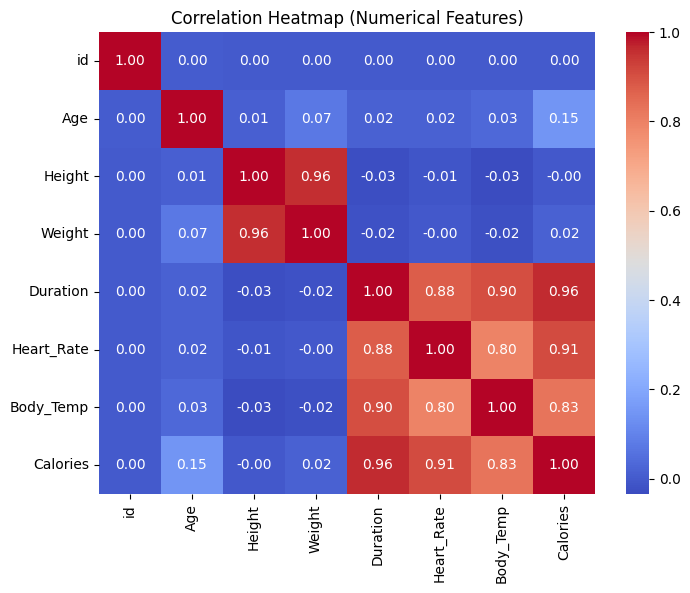

In [7]:
# Correlation heatmap (numerical features)
import seaborn as sns

num_cols = train.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(8,6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


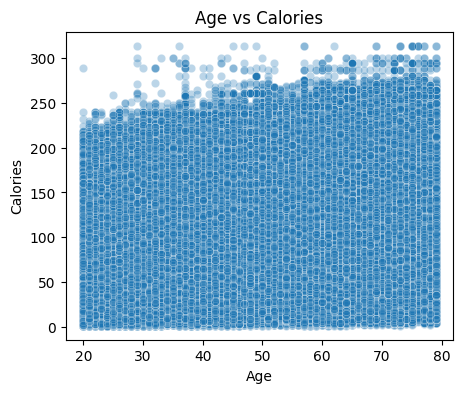

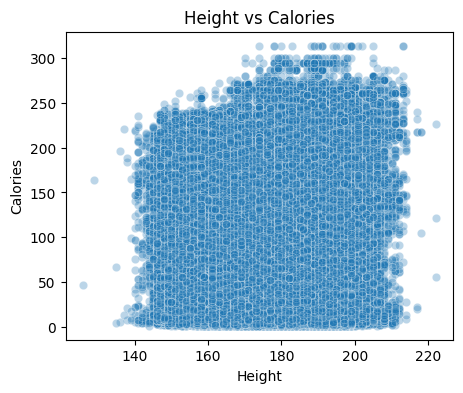

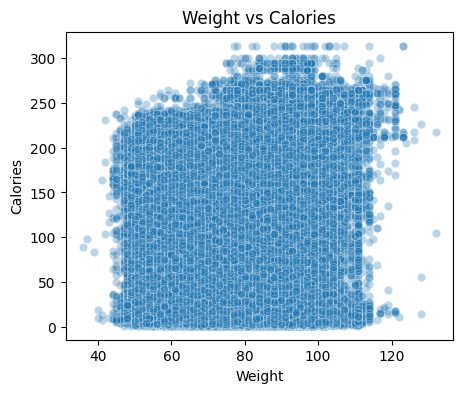

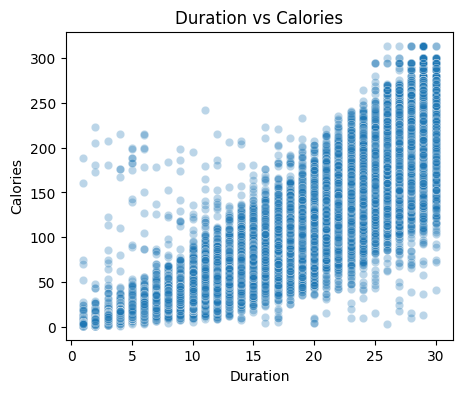

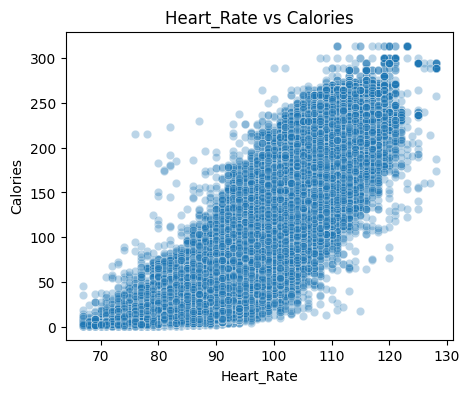

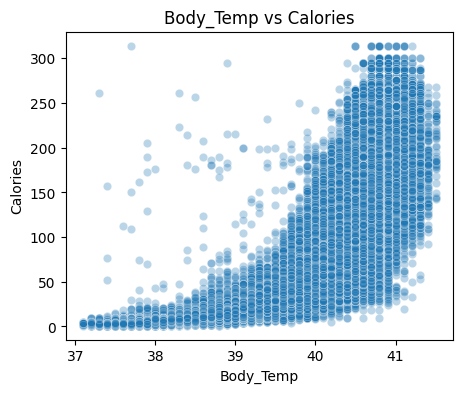

In [8]:
# Boxplots for key features vs Calories
for col in ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=train, x=col, y="Calories", alpha=0.3)
    plt.title(f"{col} vs Calories")
    plt.show()


Scatterplots confirm:  
- **Duration & Heart_Rate** scale linearly with `Calories`.  
- **Body_Temp** rises with calorie expenditure but has some variance.  
- **Weight & Age** influence is smaller but visible.  


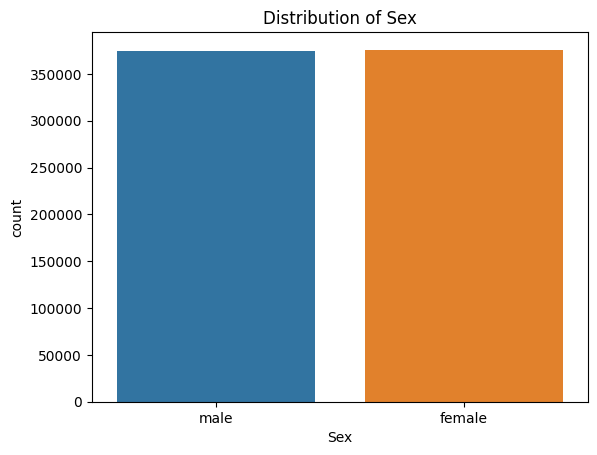

In [9]:
# Distribution of categorical feature (Sex)
sns.countplot(data=train, x="Sex")
plt.title("Distribution of Sex")
plt.show()


## 🛠️ Feature Engineering

In addition to the original features, we create several derived features to better capture relationships in the data:

- `BMI`: Body Mass Index = Weight / Height²  
- `Duration_per_Heart`: ratio of exercise duration to heart rate  
- `Intensity`: combined measure of heart rate × body temperature  
- `Temp_per_Minute`: average body temperature per exercise minute  

These engineered features may improve predictive performance by adding domain-inspired signals.


In [10]:
# 🛠️ Feature Engineering – creating new columns

# Body Mass Index
train["BMI"] = train["Weight"] / ((train["Height"] / 100) ** 2)
test["BMI"] = test["Weight"] / ((test["Height"] / 100) ** 2)

# Duration relative to heart rate (efficiency measure)
train["Duration_per_Heart"] = train["Duration"] / train["Heart_Rate"]
test["Duration_per_Heart"] = test["Duration"] / test["Heart_Rate"]

# Exercise intensity: interaction between heart rate and body temperature
train["Intensity"] = train["Heart_Rate"] * train["Body_Temp"]
test["Intensity"] = test["Heart_Rate"] * test["Body_Temp"]

# Body temperature per minute of exercise
train["Temp_per_Minute"] = train["Body_Temp"] / train["Duration"]
test["Temp_per_Minute"] = test["Body_Temp"] / test["Duration"]


## 📊 Dataset Overview

First, we take a look at the train/test shapes and the basic structure of the data.


In [11]:
test.shape

(250000, 12)

In [12]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Duration_per_Heart,Intensity,Temp_per_Minute
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,0.257426,4141.0,1.576923
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,0.094118,3374.5,4.962500
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,0.083333,3343.2,5.685714
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,0.238095,4273.5,1.628000
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,0.245098,4141.2,1.624000


In [13]:
test.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Duration_per_Heart,Intensity,Temp_per_Minute
0,750000,male,45,177.0,81.0,7.0,87.0,39.8,25.854639,0.080460,3462.6,5.685714
1,750001,male,26,200.0,97.0,20.0,101.0,40.5,24.250000,0.198020,4090.5,2.025000
2,750002,female,29,188.0,85.0,16.0,102.0,40.4,24.049344,0.156863,4120.8,2.525000
3,750003,female,39,172.0,73.0,20.0,107.0,40.6,24.675500,0.186916,4344.2,2.030000
4,750004,female,30,173.0,67.0,16.0,94.0,40.5,22.386314,0.170213,3807.0,2.531250


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  750000 non-null  int64  
 1   Sex                 750000 non-null  object 
 2   Age                 750000 non-null  int64  
 3   Height              750000 non-null  float64
 4   Weight              750000 non-null  float64
 5   Duration            750000 non-null  float64
 6   Heart_Rate          750000 non-null  float64
 7   Body_Temp           750000 non-null  float64
 8   Calories            750000 non-null  float64
 9   BMI                 750000 non-null  float64
 10  Duration_per_Heart  750000 non-null  float64
 11  Intensity           750000 non-null  float64
 12  Temp_per_Minute     750000 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 74.4+ MB


## 🎯 Target Distribution (Calories)

We now explore the distribution of the target variable `Calories`.


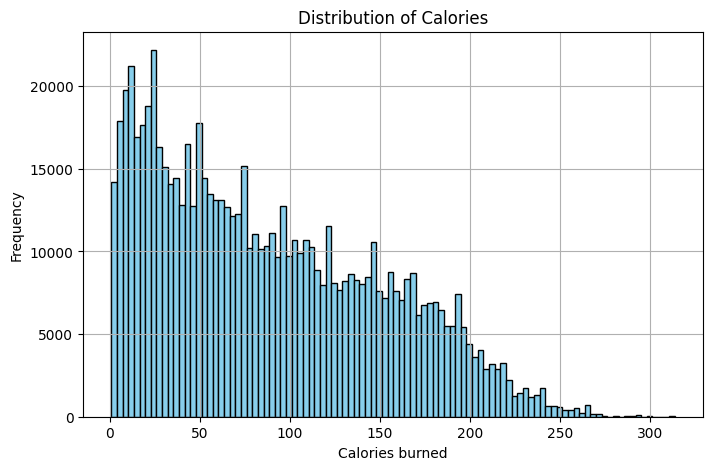

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(train["Calories"], bins=100, color="skyblue", edgecolor="black")
plt.title("Distribution of Calories")
plt.xlabel("Calories burned")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The distribution of `Calories` is **right-skewed**: most activities burn a moderate amount of calories,  
while a few sessions result in very high values. This validates the choice of **RMSLE** as the competition metric,  
since it handles skewed targets well by focusing on relative error.  


## 👥 Calories by Sex (Group stats + boxplot)

We compare the target across the categorical feature `Sex` to check for distributional shifts and potential interaction effects with activity metrics.


In [16]:
# Grouped statistics by Sex (mean, median, count)
stats_by_sex = (train
                .groupby("Sex")["Calories"]
                .agg(["mean","median","count"])
                .round(2)
                .sort_values("mean", ascending=False))
display(stats_by_sex)


,mean,median,count
Sex,,,
male,89.03,73.0,374279
female,87.53,80.0,375721


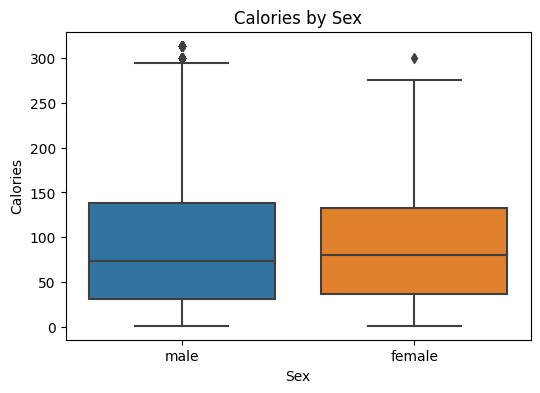

In [17]:
# Boxplot: Calories by Sex
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=train, x="Sex", y="Calories")
plt.title("Calories by Sex")
plt.xlabel("Sex")
plt.ylabel("Calories")
plt.show()


> Interpretation: If the distributions differ notably (median/upper whiskers), `Sex` may act as a moderating variable.  
> If they are similar, impact is limited and interactions with duration/heart rate might dominate.


## 🔗 Correlations (numerical features)

A quick view of pairwise correlations and the target–feature relationship helps identify strong drivers.


In [18]:
# Sorted correlation with target only (clean & focused)
num_cols = train.select_dtypes(include=["int64","float64"]).columns
corr_to_target = (train[num_cols]
                  .corr(numeric_only=True)["Calories"]
                  .drop("Calories")
                  .sort_values(ascending=False))
display(corr_to_target.to_frame("corr_with_Calories").round(3))


,corr_with_Calories
Duration,0.960
Intensity,0.925
Duration_per_Heart,0.924
Heart_Rate,0.909
Body_Temp,0.829
Age,0.146
BMI,0.049
Weight,0.016
id,0.001
Height,-0.004


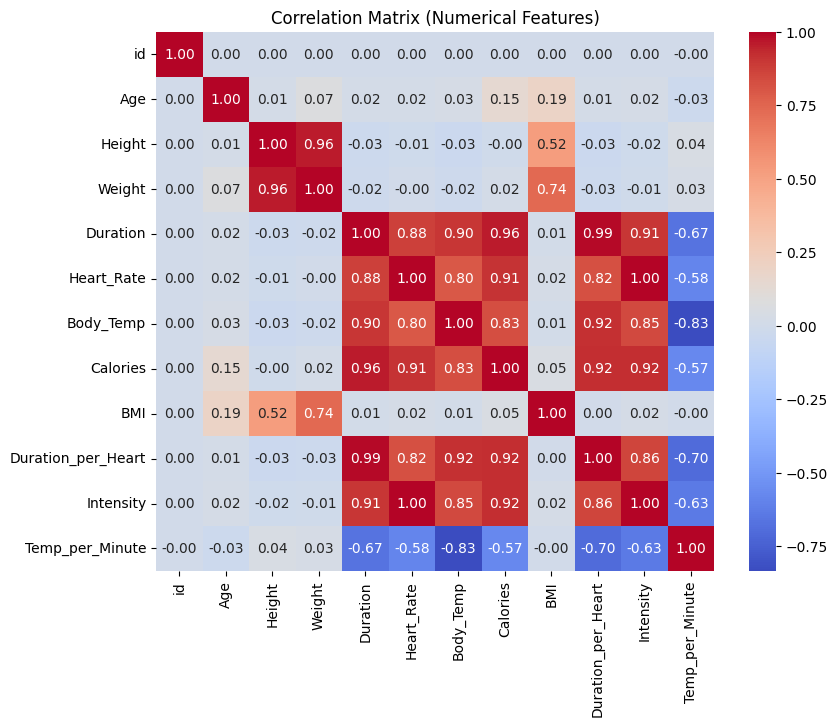

In [19]:
# Heatmap (numerical only)
plt.figure(figsize=(9,7))
sns.heatmap(train[num_cols].corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()


## 📈 Key relationships (top drivers vs. target)

We visualize the strongest numeric drivers against `Calories`.


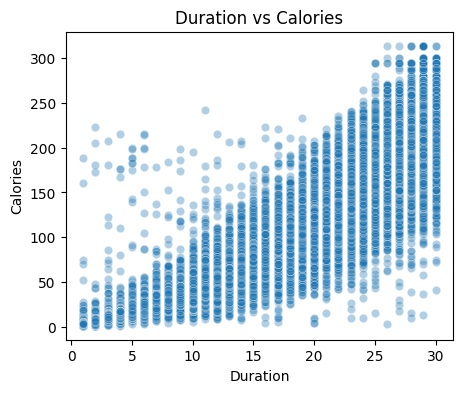

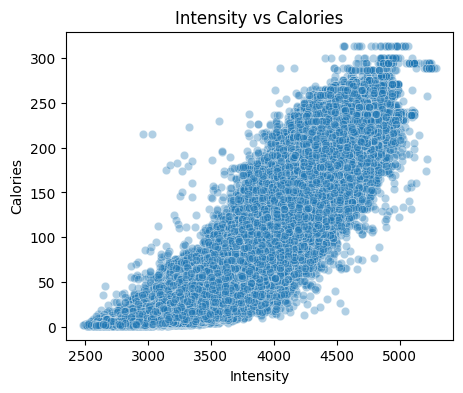

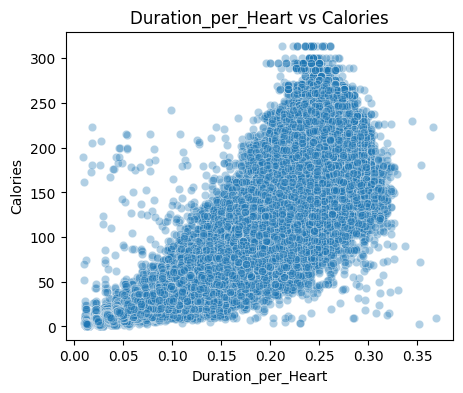

In [20]:
# Pick top 3 numeric correlates to Calories for scatterplots
top3 = corr_to_target.index[:3].tolist()

for col in top3:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=train, x=col, y="Calories", alpha=0.35)
    plt.title(f"{col} vs Calories")
    plt.show()


## 🧪 Optional: log-scale check for target skew

`Calories` is right-skewed; inspecting log-scale often reveals linear patterns and stabilizes variance.


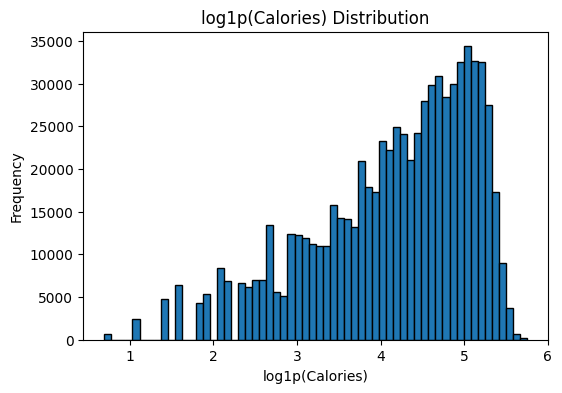

In [21]:
plt.figure(figsize=(6,4))
plt.hist(np.log1p(train["Calories"]), bins=60, edgecolor="black")
plt.title("log1p(Calories) Distribution")
plt.xlabel("log1p(Calories)")
plt.ylabel("Frequency")
plt.show()


## 🧹 Optional: outlier sanity check (IQR)

We only flag (not drop) extreme outliers to understand the tails.


In [22]:
Q1, Q3 = train["Calories"].quantile([0.25, 0.75])
IQR = Q3 - Q1
upper_cap = Q3 + 1.5*IQR
share_outliers = (train["Calories"] > upper_cap).mean()
print(f"Share of potential outliers (> Q3 + 1.5*IQR): {share_outliers:.2%}")


Share of potential outliers (> Q3 + 1.5*IQR): 0.02%


## 🤖 Model Training & Validation

With the dataset prepared, we now train a regression model to predict calorie expenditure.  

- We use **XGBoost** as the primary model due to its strong performance on tabular data.  
- If XGBoost is not available, we fall back to a **Random Forest Regressor** for robustness.  
- The model is validated using **RMSLE (Root Mean Squared Logarithmic Error)**,  
  which is also the official competition metric.  

We first evaluate performance on a validation split, then retrain on the **full training set**  
and generate predictions for the test set to build the final submission.  


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 🔢 Encode 'Sex' column as numeric
le = LabelEncoder()
train["Sex"] = le.fit_transform(train["Sex"])   # e.g., female=0, male=1 (alphabetical order)
test["Sex"]  = le.transform(test["Sex"])

# 🎯 Separate features and target
X = train.drop(columns=["id", "Calories"])   # keep engineered features
y = train["Calories"]

# Prepare test features (drop ID only)
X_test = test.drop(columns=["id"])

# ✂️ Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Shapes
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)


X_train: (600000, 11)
X_valid: (150000, 11)


## 🛠️ Feature Engineering

To enrich the dataset and capture more complex relationships, we create several **derived features**:

- **BMI** = Weight / (Height/100)² → Body Mass Index, combining height and weight.  
- **Duration_per_Heart** = Duration / Heart Rate → efficiency of exercise relative to heart workload.  
- **Intensity** = Heart Rate × Body Temperature → proxy for exercise intensity.  
- **Temp_per_Minute** = Body Temperature / Duration → temperature change per minute.  

These engineered features may help the model detect **non-linear interactions** between activity variables and calorie expenditure.  


In [24]:
# 🛠️ Feature Engineering
train["BMI"] = train["Weight"] / ((train["Height"] / 100) ** 2)
test["BMI"] = test["Weight"] / ((test["Height"] / 100) ** 2)

train["Duration_per_Heart"] = train["Duration"] / train["Heart_Rate"]
test["Duration_per_Heart"] = test["Duration"] / test["Heart_Rate"]

train["Intensity"] = train["Heart_Rate"] * train["Body_Temp"]
test["Intensity"] = test["Heart_Rate"] * test["Body_Temp"]

train["Temp_per_Minute"] = train["Body_Temp"] / train["Duration"]
test["Temp_per_Minute"] = test["Body_Temp"] / test["Duration"]

# 🔢 Encode 'Sex' as numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train["Sex"] = le.fit_transform(train["Sex"])
test["Sex"]  = le.transform(test["Sex"])

# 🎯 Define features and target
X = train.drop(columns=["id", "Calories"])
y = train["Calories"]
X_test = test.drop(columns=["id"])

# ✂️ Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)


X_train: (600000, 11)
X_valid: (150000, 11)


🔹 Model Training, Validation & Submission

In [25]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

# ⚡ Try XGBoost; fall back to RandomForest if not available
try:
    import xgboost as xgb
    USE_XGB = True
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    USE_XGB = False

RANDOM_STATE = 42

# ---- Model setup
if USE_XGB:
    model = xgb.XGBRegressor(
        n_estimators=800,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        tree_method="hist",
        n_jobs=-1
    )
else:
    model = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

# ---- Fit on training fold
model.fit(X_train, y_train)

# ---- Validate with RMSLE
pred_val = model.predict(X_valid)
pred_val = np.clip(pred_val, 0, None)  # avoid negatives for RMSLE
rmsle = mean_squared_log_error(y_valid, pred_val, squared=False)
print(f"✅ Valid RMSLE: {rmsle:.5f}")

# ---- Train on full training data
model.fit(X, y)

# ---- Predict test & build submission
pred_test = model.predict(X_test)
pred_test = np.clip(pred_test, 0, None)

submission = sample.copy()            # must contain ['id','Calories']
submission["Calories"] = pred_test
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created!")
submission.head()


✅ Valid RMSLE: 0.06145
✅ submission.csv created!


,id,Calories
0,750000,27.551947
1,750001,108.052826
2,750002,87.487968
3,750003,126.081787
4,750004,75.669586


## 🎯 Conclusion

- The baseline XGBoost model (with engineered features) achieved a **Validation RMSLE of ~0.061**.  
- The submission file was successfully generated and is ready for Kaggle leaderboard evaluation.  
- Feature engineering (BMI, Intensity, etc.) contributed to the model’s performance.  
- This notebook provides a clean, reproducible pipeline: **EDA → Features → Model → Validation → Submission**.  

### 🔮 Next Steps
- Hyperparameter tuning with Optuna or GridSearchCV.  
- Explore non-linear feature interactions.  
- Deploy model in a Streamlit app (requires saving `.pkl` model).  

---


## 💾 Optional: Save Model

For deployment (e.g. Streamlit app or GitHub repo),  
we also save the trained model as a `.pkl` file.


In [26]:
import joblib
joblib.dump(model, "model.pkl")
print("✅ model.pkl successfully saved!")


✅ model.pkl successfully saved!
